In [2]:
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR 
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf 
print(tf.__version__)

import warnings
warnings.simplefilter(action='ignore')

2.6.0


In [3]:
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams["figure.figsize"] = (20, 6) 
sns.set(context="paper", font="monospace") 

In [4]:
df = pd.read_csv('datasets/throughput_metrics.csv', parse_dates=['Time'], index_col='Time')
# df.reset_index(inplace=True)
df.head() 

,SiteA,SiteB,SiteC,SiteD,SiteE,SiteF
Time,,,,,,
2018-01-01 08:00:00,1.411093e+10,1.109243e+09,8.289831e+07,56650005.21,1.117868e+07,827420.9772
2018-01-01 09:00:00,1.345362e+10,1.242256e+09,4.375739e+04,49307351.26,7.070847e+06,913017.6007
2018-01-01 10:00:00,1.216888e+10,2.006322e+09,4.315725e+04,56843652.59,5.132826e+07,874471.3644
2018-01-01 11:00:00,1.123120e+10,1.073181e+09,8.277154e+07,46645240.59,5.217827e+06,837246.7783
2018-01-01 12:00:00,1.078085e+10,8.645069e+08,3.343548e+04,30966947.37,7.495363e+06,827143.7497


In [5]:
df.shape 

(8760, 6)

In [6]:
sum(df.isna().sum())

0

In [1]:
# fig = make_subplots(rows=6, cols=1, subplot_titles=df.columns,
#                     vertical_spacing=0.05)

# for i, col in enumerate(df.columns):
#     fig.add_trace(go.Scatter(x=df.index, y=df[col],  
#                              marker = dict(size = 10, 
#                                            color = 'blue'),
#                             textfont=dict(
#                                 color='black',
#                                 size=18,  
#                                 family='Times New Roman')),
#                 row=i+1, col=1)
    
# fig.update_xaxes(
#     rangeselector=dict(
#         buttons=list([
#             dict(count=1, label="1m", step="month", stepmode="backward"),
#             dict(count=6, label="6m", step="month", stepmode="backward"),
#             dict(count=1, label="YTD", step="year", stepmode="todate"),
#             dict(count=1, label="1y", step="year", stepmode="backward"),
#             dict(step="all")
#         ])
#     )
# )
# fig.update_layout(showlegend=False, autosize=False,
#     width=1300,
#     height=1500,
#     )
# fig.show()  

In [8]:
# c = 1
# fig = plt.figure(figsize=(20,15))
# for col in df.columns:
#     plt.subplot(3, 2, c)
#     plt.title(f'{col}', size=15)
#     plt.tight_layout()
#     plt.plot(df[col])
#     c += 1
# plt.show() 

In [9]:
# missing value treatment
for i in ['SiteB', 'SiteE']:
    df[i][df[i] == 0] = df[i].mean() 

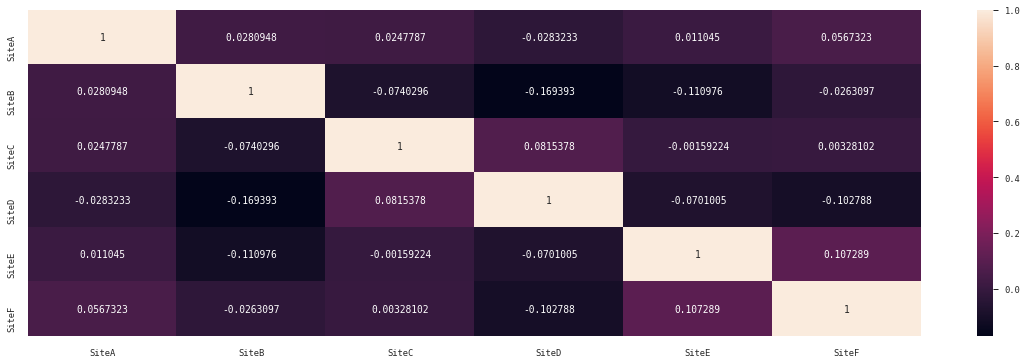

In [11]:
sns.heatmap(df.corr(), fmt='g', annot=True); 

In [12]:
# checking stationarity 
cj_stat = coint_johansen(df,-1,1).eig 
print(cj_stat) 

[0.38782114 0.16822476 0.07955193 0.04133012 0.02690916 0.00513086]


### VAR

In [13]:
nobs = 1
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape) 

(8759, 6)
(1, 6)


In [14]:
df_test 

,SiteA,SiteB,SiteC,SiteD,SiteE,SiteF
Time,,,,,,
2019-01-01 07:00:00,8.675575e+09,1.228012e+10,73190.10285,56298747.51,10973382.24,907757.851


In [40]:
# fit the model
model = VAR(df_train)
model_fit = model.fit() 

In [16]:
# Input data for forecasting
forecast_input = df_train.values[-nobs:]
forecast_input 

array([[6.88469466e+09, 9.62731719e+09, 7.31901028e+04, 6.26614479e+07,
        6.15230605e+07, 8.79444753e+05]])

In [18]:
df_train.tail()

,SiteA,SiteB,SiteC,SiteD,SiteE,SiteF
Time,,,,,,
2019-01-01 02:00:00,4.724311e+09,9.419182e+09,6.413882e+04,47729513.75,47515761.79,871565.3105
2019-01-01 03:00:00,4.031000e+09,8.216592e+09,4.036552e+07,58923296.12,11633975.46,886902.6908
2019-01-01 04:00:00,8.101920e+09,8.529913e+09,4.194376e+07,52267423.90,9186894.13,875737.4867
2019-01-01 05:00:00,7.529417e+09,8.250299e+09,4.499228e+04,54076247.79,55891811.65,875879.5356
2019-01-01 06:00:00,6.884695e+09,9.627317e+09,7.319010e+04,62661447.92,61523060.49,879444.7533


In [17]:
forecast_input == df_test.values

array([[False, False,  True, False, False, False]])

In [18]:
# Forecast
fc = model_fit.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns)
df_forecast 

,SiteA,SiteB,SiteC,SiteD,SiteE,SiteF
Time,,,,,,
2019-01-01 07:00:00,7.546767e+09,9.795331e+09,2.600965e+07,6.448225e+07,6.392096e+07,1.032568e+06


In [19]:
result = dict()
# check rmse 
for i in df.columns: 
    result[f'{i} RMSE'] = np.sqrt(mean_squared_error(df_forecast[i], df_test[i]))
    # print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(df_forecast[i], df_test[i])))
print(result) 

{'SiteA RMSE': 1128807727.8593187, 'SiteB RMSE': 2484787615.5402966, 'SiteC RMSE': 25936459.75449342, 'SiteD RMSE': 8183503.121821545, 'SiteE RMSE': 52947582.644412406, 'SiteF RMSE': 124809.94446083612}


In [20]:
# make final predictions
model = VAR(df)
model_fit = model.fit() 
yhat = model_fit.forecast(model_fit.y, steps=150)
print(yhat.shape)  

(150, 6)


In [21]:
len(yhat)

150

In [22]:
def forecast_to_df(data, forecast):
    ''' Convert forecast output array to dataframe using input data columns
    and last index '''
    date = data[-1:].index 
    future_date = []
    for i in range(len(forecast)): 
        date += timedelta(hours=1)
        future_date.append(date)
    yhat_df = pd.DataFrame(yhat, columns=data.columns, index=list(map(list, zip(*future_date))))
    # convert index values to datetime 
    idx = yhat_df.index.get_level_values(0).astype(str) 
    yhat_df.index = pd.to_datetime(idx)
    yhat_df.index.rename('Time', inplace=True)
    
    return yhat_df 

In [23]:
yhat_df = forecast_to_df(df, yhat)
yhat_df.head()

,SiteA,SiteB,SiteC,SiteD,SiteE,SiteF
Time,,,,,,
2019-01-01 08:00:00,9.067830e+09,1.231458e+10,2.528002e+07,5.850849e+07,1.786575e+07,1.031200e+06
2019-01-01 09:00:00,9.415124e+09,1.226698e+10,2.248078e+07,6.105517e+07,2.465994e+07,1.088993e+06
2019-01-01 10:00:00,9.714108e+09,1.221955e+10,2.300308e+07,6.309254e+07,3.062072e+07,1.120930e+06
2019-01-01 11:00:00,9.969166e+09,1.216593e+10,2.309472e+07,6.482043e+07,3.592854e+07,1.138904e+06
2019-01-01 12:00:00,1.018543e+10,1.210918e+10,2.321467e+07,6.628496e+07,4.064724e+07,1.149802e+06


In [24]:
forecast_df = yhat_df.copy()
forecast_df.reset_index(level=0, inplace=True)
# forecast_df.style.hide_index() 

In [25]:
yhat_df.shape 

(150, 6)

In [26]:
def make_plot(df1, df2, names):
    fig = make_subplots(rows=6, cols=1, subplot_titles=df1.columns,
                        vertical_spacing=0.05)

    for i, col in enumerate(df.columns):
        fig.add_trace(go.Scatter(name=names[0], x=df1.index, y=df1[col],  
                                marker = dict(size = 10, 
                                            color = 'blue'),
                                textfont=dict(
                                    color='black',
                                    size=18,  
                                    family='Times New Roman')),
                    row=i+1, col=1)
        fig.add_trace(go.Scatter(name=names[1], x=df2.index, y=df2[col],  
                                marker = dict(size = 10, 
                                            color = 'red')),
                    row=i+1, col=1) 
        
    fig.update_xaxes(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    fig.update_layout(autosize=False,
        width=1300,
        height=1500,
        )
    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ))
    names = set()
    fig.for_each_trace(
        lambda trace:
            trace.update(showlegend=False)
            if (trace.name in names) else names.add(trace.name))

    fig.show() 

In [2]:
# make_plot(df, yhat_df, ['actual', 'forecast'])

In [1]:
# c = 1
# fig = plt.figure(figsize=(20,15))
# for col in df.columns:
#     plt.subplot(3, 2, c)
#     plt.title(f'{col}', size=15)
#     plt.tight_layout()
#     # plt.plot(df[8700:][col])
#     plt.plot(df_test[col], label='actual')
#     plt.plot(df_forecast[col], label='forecast')
#     plt.legend()
#     c += 1
# plt.show() 

### LSTM

In [27]:
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg 

In [28]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)
df_reframed = series_to_supervised(scaled) 
df_reframed 

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
1,0.183318,0.021212,0.329815,0.155905,0.007080,0.017119,0.174579,0.023756,0.000134,0.135429,0.004478,0.020384
2,0.174579,0.023756,0.000134,0.135429,0.004478,0.020384,0.157498,0.038367,0.000131,0.156445,0.032509,0.018914
3,0.157498,0.038367,0.000131,0.156445,0.032509,0.018914,0.145031,0.020522,0.329310,0.128006,0.003305,0.017494
4,0.145031,0.020522,0.329310,0.128006,0.003305,0.017494,0.139044,0.016532,0.000093,0.084286,0.004747,0.017108
5,0.139044,0.016532,0.000093,0.084286,0.004747,0.017108,0.138376,0.040076,0.000687,0.135176,0.003450,0.017347
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.058520,0.180123,0.000215,0.131029,0.030094,0.018803,0.049302,0.157126,0.160575,0.162244,0.007368,0.019388
8756,0.049302,0.157126,0.160575,0.162244,0.007368,0.019388,0.103426,0.163118,0.166855,0.143684,0.005819,0.018962
8757,0.103426,0.163118,0.166855,0.143684,0.005819,0.018962,0.095815,0.157771,0.000139,0.148728,0.035399,0.018967
8758,0.095815,0.157771,0.000139,0.148728,0.035399,0.018967,0.087243,0.184103,0.000251,0.172668,0.038966,0.019103


In [29]:
df_reframed.columns 

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)',
       'var6(t)'],
      dtype='object')

In [30]:
# split into train and test sets
values = df_reframed.values
n_train_hours = 300 * 24 # first 300 days for train 
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-6], train[:, -6:]
test_X, test_y = test[:, :-6], test[:, -6:] 
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(7200, 1, 6) (7200, 6) (1559, 1, 6) (1559, 6)


In [31]:
print(df_reframed.shape[0])
print(train_X.shape[0] + test_X.shape[0]) 

8759
8759


In [3]:
# make_plot(df.iloc[:n_train_hours, :], df.iloc[n_train_hours:, :], 'Training set', 'Test set')

In [37]:
# design network 
lstm_model = tf.keras.models.Sequential([
tf.keras.layers.LSTM(200, return_sequences=True, 
                            input_shape=(train_X.shape[1], train_X.shape[2])),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.LSTM(150),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(6)
])
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 200)            165600    
_________________________________________________________________
dense_4 (Dense)              (None, 1, 20)             4020      
_________________________________________________________________
lstm_3 (LSTM)                (None, 150)               102600    
_________________________________________________________________
dense_5 (Dense)              (None, 20)                3020      
_________________________________________________________________
dense_6 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                

In [38]:
model_path = 'models/LSTM.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks = [early_stopings,checkpoint] 

In [39]:
# fit network
history = lstm_model.fit(train_X, train_y, epochs=20, batch_size=72, 
                         validation_data=(test_X, test_y), verbose=2, 
                         shuffle=False, callbacks=callbacks) 

2021-12-17 19:51:46.944643: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
100/100 - 8s - loss: 0.0812 - val_loss: 0.0544
Epoch 2/20
100/100 - 1s - loss: 0.0698 - val_loss: 0.0513
Epoch 3/20
100/100 - 2s - loss: 0.0658 - val_loss: 0.0445
Epoch 4/20
100/100 - 1s - loss: 0.0610 - val_loss: 0.0374
Epoch 5/20
100/100 - 2s - loss: 0.0561 - val_loss: 0.0343
Epoch 6/20
100/100 - 2s - loss: 0.0542 - val_loss: 0.0329
Epoch 7/20
100/100 - 2s - loss: 0.0537 - val_loss: 0.0327
Epoch 8/20
100/100 - 2s - loss: 0.0530 - val_loss: 0.0337
Epoch 9/20
100/100 - 2s - loss: 0.0527 - val_loss: 0.0327
Epoch 10/20
100/100 - 2s - loss: 0.0525 - val_loss: 0.0330
Epoch 11/20
100/100 - 2s - loss: 0.0523 - val_loss: 0.0342
Epoch 12/20
100/100 - 2s - loss: 0.0521 - val_loss: 0.0325
Epoch 13/20
100/100 - 2s - loss: 0.0519 - val_loss: 0.0336
Epoch 14/20
100/100 - 2s - loss: 0.0517 - val_loss: 0.0337
Epoch 15/20
100/100 - 2s - loss: 0.0517 - val_loss: 0.0329
Epoch 16/20
100/100 - 2s - loss: 0.0517 - val_loss: 0.0331
Epoch 17/20
100/100 - 2s - loss: 0.0514 - val_loss: 0.0327
Epoch 

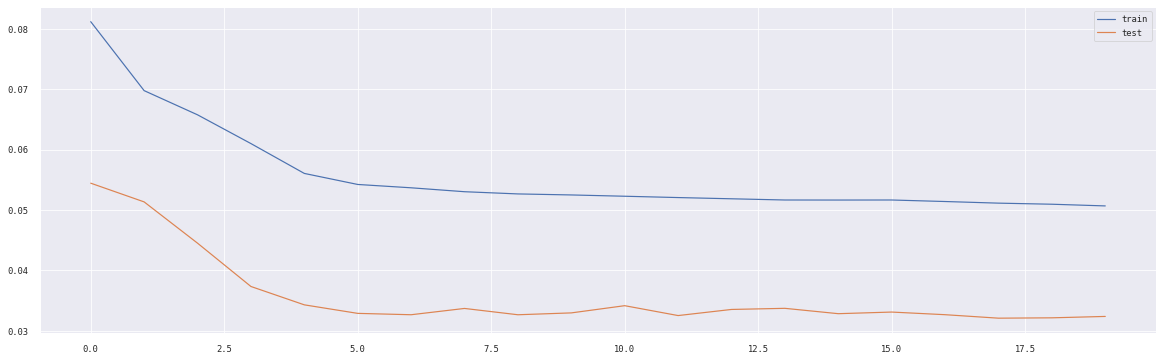

In [40]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show() 

In [41]:
# make a prediction
yhat = lstm_model.predict(test_X)

In [42]:
# invert scaling for forecast and actual 
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)
# calculate RMSE
result_lstm = dict()
for i, col in enumerate(df.columns):
    result_lstm[f'{col} RMSE'] = np.sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i])).round(3)
print(result_lstm) 

{'SiteA RMSE': 4022805930.458, 'SiteB RMSE': 3037870523.088, 'SiteC RMSE': 23378984.05, 'SiteD RMSE': 16939930.83, 'SiteE RMSE': 37644258.228, 'SiteF RMSE': 617504.738}


In [1]:
# c = 1
# fig = plt.figure(figsize=(20,15))
# for i, col in enumerate(df.columns):
#     plt.subplot(3, 2, c)
#     plt.title(f'{col}', size=15)
#     plt.tight_layout()
#     # plt.plot(df[8700:][col])
#     plt.plot(inv_yhat[:, i], label='forecast')
#     plt.plot(inv_y[:, i], label='actual')
#     plt.legend()
#     c += 1
# plt.show() 